# Chunking Optimization Techniques
* Notebook by Adam Lang
* Date: 1/27/2025

# Overview
* If you are building a RAG-LLM application, the text or document chunking technique(s) you choose can make or break your application.
* Some people choose a "default" chunking/splitting strategy for every use case, but there is no "one size its all" when working with data and LLMs.


## Recent Research
* ChromaDB released a paper in July 2024 that evaluated multiple variations of common chunking techniques, as well as establishing some novel chunking techniques themselves.

* The purpose of their work was to try and find the best overall method for preparing unstructured text data for downstream RAG-LLM applications.

## Chunking Optimization Techniques to cover
* This is NOT an exhaustive list but this is based on the [ChromaDB research paper](https://research.trychroma.com/evaluating-chunking)

1. Character/Token Based Chunking

2. Recursive Character/Token Based Chunking

3. Semantic Chunking

4. Cluster Semantic Chunking

5. LLM Semantic Chunking

# Install Dependencies
* ChromaDB has [open sourced their code in the repo](https://github.com/brandonstarxel/chunking_evaluation) we can install below.

In [1]:
%%capture
!pip install git+https://github.com/brandonstarxel/chunking_evaluation.git

# Import Libraries

In [2]:
# Main Chunking Functions
from chunking_evaluation.chunking import (
    ClusterSemanticChunker,
    LLMSemanticChunker,
    FixedTokenChunker,
    RecursiveTokenChunker,
    KamradtModifiedChunker #semantic chunker
)
# Additional Data Science and ML Dependencies
import tiktoken
from chromadb.utils import embedding_functions
from chunking_evaluation.utils import openai_token_count
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Example Text Resource
* We will utilize a well known open source book "Adventures of Huckleberry Finn" by Mark Twain
* Available here for free: https://www.gutenberg.org/ebooks/76


In [3]:
## open file
file_path = '/content/drive/MyDrive/Colab Notebooks/RAG_techniques/Adventures of Huckleberry Finn.txt'

with open(file_path, 'r', encoding='utf-8') as file:
  document = file.read()

## print some of file
print("First 1000 characters: ", document[:1000])

First 1000 characters:  The Project Gutenberg eBook of Adventures of Huckleberry Finn
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: Adventures of Huckleberry Finn

Author: Mark Twain

Illustrator: E. W. Kemble

Release date: June 29, 2004 [eBook #76]
                Most recently updated: November 16, 2023

Language: English

Credits: David Widger


*** START OF THE PROJECT GUTENBERG EBOOK ADVENTURES OF HUCKLEBERRY FINN ***




ADVENTURES
OF
HUCKLEBERRY FINN

(Tom Sawyer’s Comrade)

By Mark Twain




CONTENTS.

CHAPTER I.
Civilizing Huck.—Miss Watson.—Tom Sawyer Waits.

CHAPTER II.
T

# Analyzing Chunks
* We need a helper function for this.

In [4]:
def analyze_chunks(chunks, use_tokens=False):
    # Print the chunks of interest
    print("\nNumber of Chunks:", len(chunks))
    print("\n", "="*50, "200th Chunk", "="*50,"\n", chunks[199])
    print("\n", "="*50, "201st Chunk", "="*50,"\n", chunks[200])

    chunk1, chunk2 = chunks[199], chunks[200]

    if use_tokens:
        encoding = tiktoken.get_encoding("cl100k_base")
        tokens1 = encoding.encode(chunk1)
        tokens2 = encoding.encode(chunk2)

        # Find overlapping tokens
        for i in range(len(tokens1), 0, -1):
            if tokens1[-i:] == tokens2[:i]:
                overlap = encoding.decode(tokens1[-i:])
                print("\n", "="*50, f"\nOverlapping text ({i} tokens):", overlap)
                return
        print("\nNo token overlap found")
    else:
        # Find overlapping characters
        for i in range(min(len(chunk1), len(chunk2)), 0, -1):
            if chunk1[-i:] == chunk2[:i]:
                print("\n", "="*50, f"\nOverlapping text ({i} chars):", chunk1[-i:])
                return
        print("\nNo character overlap found")

# 1. Character Based Text Splitting
* This is at its core the most simplest and one of the most common methods used for chunking text for RAG.
* **This method counts the number of characters and splits at that count.**

In [6]:
## function to chunk text
def chunk_text(document, chunk_size, overlap):
    chunks = []
    stride = chunk_size - overlap
    current_idx = 0

    while current_idx < len(document):
        # Take chunk_size characters starting from current_idx
        chunk = document[current_idx:current_idx + chunk_size]
        if not chunk:  # Break if we're out of text
            break
        chunks.append(chunk)
        current_idx += stride  # Move forward by stride

    return chunks

**Choose an arbitrary chunk size, lets say 400 characters with no overlap**

In [7]:
## apply chunk_text function with chunk size of 400 and NO OVERLAP
character_chunks = chunk_text(document, chunk_size=400, overlap=0)


## analyze chunks with helper function
analyze_chunks(character_chunks)


Number of Chunks: 1476

 ================================================== 200th Chunk ================================================== 
 when I waked that I judged it was after eight
o’clock. I laid there in the grass and the cool shade thinking about
things, and feeling rested and ruther comfortable and satisfied. I
could see the sun out at one or two holes, but mostly it was big trees
all about, and gloomy in there amongst them. There was freckled places
on the ground where the light sifted down through the leaves, and the
freckl

 ================================================== 201st Chunk ================================================== 
 ed places swapped about a little, showing there was a little
breeze up there. A couple of squirrels set on a limb and jabbered at me
very friendly.

I was powerful lazy and comfortable—didn’t want to get up and cook
breakfast. Well, I was dozing off again when I thinks I hears a deep
sound of “boom!” away up the river. I rouses up, and r

**Double the chunk size to 800 with a 400 character overlap**

In [8]:
## double chunk size and add overlap
character_overlap_chunks = chunk_text(document, chunk_size=800, overlap=400)

## analyze chunks again
analyze_chunks(character_overlap_chunks)


Number of Chunks: 1476

 ================================================== 200th Chunk ================================================== 
 when I waked that I judged it was after eight
o’clock. I laid there in the grass and the cool shade thinking about
things, and feeling rested and ruther comfortable and satisfied. I
could see the sun out at one or two holes, but mostly it was big trees
all about, and gloomy in there amongst them. There was freckled places
on the ground where the light sifted down through the leaves, and the
freckled places swapped about a little, showing there was a little
breeze up there. A couple of squirrels set on a limb and jabbered at me
very friendly.

I was powerful lazy and comfortable—didn’t want to get up and cook
breakfast. Well, I was dozing off again when I thinks I hears a deep
sound of “boom!” away up the river. I rouses up, and rests on my elbow
and listens; pretty soon I hears it again. I

 ================================================== 201s

## Summary
* We can see the differences between overlap and no overlap above.
* The advantage of overlap is to "preserve information",
  * However, with overlap we also get duplication of information which is a problem for RAG-LLM systems in retrieval.
* But without overlap we also lose context and semantic information.

# 2. Token Text Splitting/Chunking
* This is considered a "step up" from character based chunking.
* Using the [OpenAI tokenization visualizer](https://platform.openai.com/tokenizer) we can see how 1 of the chunks from above is visualized on a token level using the `GPT-4o and GPT-4o mini` models:

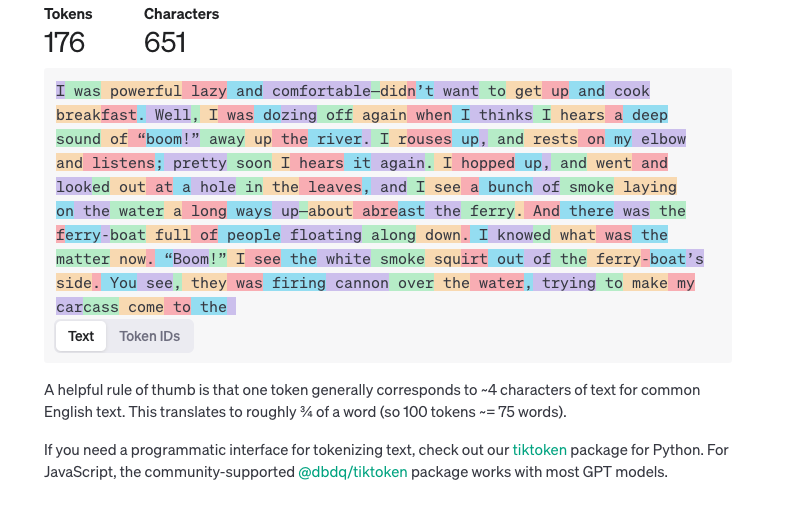




* However, tokens are NOT the same for every LLM. We can demonstrate this by using the [Xenova Tokenizer Playground from Hugging Face](https://huggingface.co/spaces/Xenova/the-tokenizer-playground)
* If we use the same passage from the Huckleberry Finn book above but with a different open source LLM model -- **Mistral v3**, there are 192 tokens which as we can see this is more than the GPT model had above.

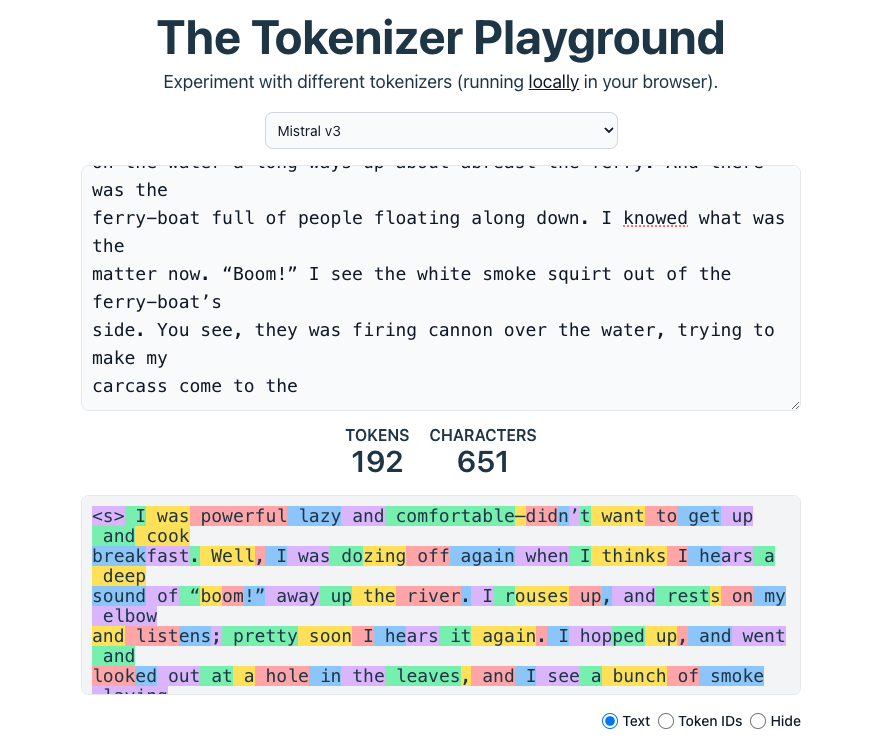

## Token Takeaways
* Its important to remember that LLMs don't operate at the character level!
* **Instead LLMs use tokens, or common sequences of characters that represent frequent words, word pieces, and subwords.**

  * For example, the word 'hamburger' when input to GPT-4's tokenizer is split into the tokens ['h', 'amburger'].
  * Common words like 'the' or 'and' are typically single tokens.

* This means character-based splitting isn't ideal because:

1. **Variability in token counts**
  * A 500-character chunk might contain anywhere from 100-500 tokens depending on the text

2. **Varies by language**
  * Different languages and character sets encode to very different numbers of tokens
  * We might hit token limits in our LLM without realizing it.


## Most common tokenizer
* Tokenizers like `cl100k_base` are most commonly used and implement Byte-Pair Encoding (BPE) - a compression algorithm that creates a vocabulary by iteratively merging the most frequent pairs of bytes or characters.

  * The '100k' refers to its vocab size, determining the balance between compression and representation granularity.

When feeding inputs to an LLM, the first step is tokenizing the text so that it can be processed by the underlying neural network.

  * The LLM outputs tokens which are decoded back into words. Let's see how this works...

### Encoding words

In [10]:
import tiktoken

# Loading cl100k_base tokenizer
encoder = tiktoken.get_encoding("cl100k_base")

# Text Example
text = "hamburger"
tokens = encoder.encode(text)

print("Tokens:", tokens)

Tokens: [71, 47775]


### Decoding words

In [11]:
## decoding the tokens
for i in range(len(tokens)):
    print(f"Token {i+1}:", encoder.decode([tokens[i]]))

print("Full Decoding: ", encoder.decode(tokens))

Token 1: h
Token 2: amburger
Full Decoding:  hamburger


## Helper function for counting tokens

In [12]:
## define helper function

def count_tokens(text, model="cl100k_base"):
    """Count tokens in a text string using tiktoken"""
    encoder = tiktoken.get_encoding(model)
    return print(f"Number of tokens: {len(encoder.encode(text))}")


**Chunk Size of 400 Tokens, 0 Overlap**

In [13]:
## count tokens instead of characters
fixed_token_chunker = FixedTokenChunker(
    chunk_size=400,
    chunk_overlap=0,
    encoding_name="cl100k_base"
)

## get chunks
token_chunks = fixed_token_chunker.split_text(document)


## analyze chunks
analyze_chunks(token_chunks, use_tokens=True)


Number of Chunks: 395

 ================================================== 200th Chunk ================================================== 
  danced off to
the dressing-room, and everybody just a-howling with pleasure and
astonishment.

Then the ring-master he see how he had been fooled, and he _was_ the
sickest ring-master you ever see, I reckon. Why, it was one of his own
men! He had got up that joke all out of his own head, and never let on
to nobody. Well, I felt sheepish enough to be took in so, but I
wouldn’t a been in that ring-master’s place, not for a thousand dollars.
I don’t know; there may be bullier circuses than what that one was, but
I never struck them yet. Anyways, it was plenty good enough for _me;_
and wherever I run across it, it can have all of _my_ custom every
time.

Well, that night we had _our_ show; but there warn’t only about twelve
people there—just enough to pay expenses. And they laughed all the
time, and that made the duke mad; and everybody left, anyway,

In [14]:
## lets see the first chunk
count_tokens(token_chunks[0])

Number of tokens: 400


**Chunk size of 400 tokens with 200 token overlap**
* Counting tokens again

In [15]:
## counting tokens
fixed_token_chunker = FixedTokenChunker(
    chunk_size=400,
    chunk_overlap=200,
    encoding_name="cl100k_base"
)

## get token overlap
token_overlap_chunks = fixed_token_chunker.split_text(document)


## analyze chunks
analyze_chunks(token_overlap_chunks, use_tokens=True)


Number of Chunks: 788

 ================================================== 200th Chunk ================================================== 
 _ like it? So says I to Jim:

“The first light we see we’ll land a hundred yards below it or above
it, in a place where it’s a good hiding-place for you and the skiff,
and then I’ll go and fix up some kind of a yarn, and get somebody to go
for that gang and get them out of their scrape, so they can be hung
when their time comes.”

But that idea was a failure; for pretty soon it begun to storm again,
and this time worse than ever. The rain poured down, and never a light
showed; everybody in bed, I reckon. We boomed along down the river,
watching for lights and watching for our raft. After a long time the
rain let up, but the clouds stayed, and the lightning kept whimpering,
and by-and-by a flash showed us a black thing ahead, floating, and we
made for it.

It was the raft, and mighty glad was we to get aboard of it again. We
seen a light now away d

### Summary
* Token based chunking makes a lot of sense given that LLMs communicate and process information on a token level.
* We can see the chunks that are produced by token chunking make more sense but are still not ideal as there is still the possibility of information loss and information overlap (duplication).
* Let's see if we can improve upon this.

# 3. Recursive Character Text Splitting/Chunking
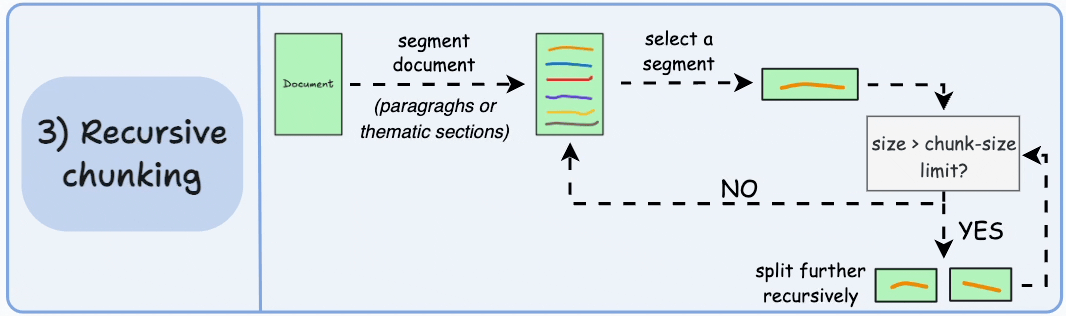

## Advantages of Recursively Splitting Text
* We saw with Character and Token splitting that counting tokens or characters can only get us so much and results in information loss or information duplication/overlap.
* When we as humans write, we naturally separate text into paragraphs, sentences, and other logical units.

  * The recursive character text splitter tries to mimic this by intelligently splitting text by looking for natural separators in order, while respecting a maximum character length.

## How Recursive Character Text Splitting works?

1. Splitter makes a complete pass over the entire document using paragraph breaks `(\n\n)`, creating an initial set of chunks.

2. Then for any chunks that exceed the size limit, it recursively processes them using progressively smaller separators:

    * a. First tries to split on paragraph breaks (\n\n)
    * b. If chunks are still too big, tries line breaks (\n)
    * c. Then sentence boundaries (., ?, !)
    * d. Then words ( )
    * e. Finally, if no other separators work, splits on individual characters ("")

In the end, the splitter preserves as much natural structure as possible - only filtering down to smaller separators when necessary to meet the size limit.

A chunk that is already small enough stays intact, while larger chunks get progressively broken down until they fit.

## Important Distinctions about RecursiveCharacterTextSplitter and TokenTextSplitter
* The [ChromaDB research paper](https://research.trychroma.com/evaluating-chunking#langchain_recursive_text_splitter) took a critical look at the 2 most popular methods:
  * RecursiveCharacterTextSplitter
  * TokenTextSplitter
  
* These 2 methods are some of the most popular chunking methods, and the default used by many RAG systems.
* However, these chunking methods are **insensitive to the semantic content of the corpus**, relying instead on the position of character sequences to divide documents into chunks, up to a maximum specified length.
* ChromaDB utilized the very popular implementation of the Langchain library.
  * Their findings were interesting:
    
    1. They found that it was necessary to alter some defaults to achieve fair results
    2. By default, the `RecursiveCharacterTextSplitter` uses the following separators: `["\n\n", "\n", " ", ""]`.
    3. They found this would commonly result in **very short chunks, which performed poorly in comparison to `TokenTextSplitter` which produces chunks of a fixed length by default.**
    4. Therefore, they used these additional sentence based separators: `["\n\n", "\n", ".", "?", "!", " ", ""]` to improve chunk quality and size.

**Chunk size of 800 Characters with 0 overlap**
* Let's test this out...

In [16]:
## init recursive splitter
recursive_character_chunker = RecursiveTokenChunker(
    chunk_size=800,  # Character Length
    chunk_overlap=0,  # Overlap
    length_function=len,  # Character length with len()
    separators=["\n\n", "\n", ".", "?", "!", " ", ""] # adding ChromaDB separators
)

## create recursive chunks
recursive_character_chunks = recursive_character_chunker.split_text(document)

## analyze chunks
analyze_chunks(recursive_character_chunks, use_tokens=False)


Number of Chunks: 1019

 ================================================== 200th Chunk ================================================== 
 all day to get the hang of the things, and by-and-by I could do pretty
well in them, only Jim said I didn’t walk like a girl; and he said I
must quit pulling up my gown to get at my britches-pocket. I took
notice, and done better.

 ================================================== 201st Chunk ================================================== 
 I started up the Illinois shore in the canoe just after dark.

No character overlap found


In [17]:
## lets count the length of one of these chunks...
len(recursive_character_chunks[199]) ## 200th chunk above

230

### Summary
* **Whoa! This is crazy, we wanted exact chunk sizes of 800 characters but as we can see the chunk size above is 230 characters!**
* What we see above is that **we don't get exact splits** - a chunk might be 550 characters long because that's where a **paragraph or sentence naturally ends**, rather than forcing the full 800 character limit.
* The chunker prioritizes maintaining these natural text boundaries over hitting the exact maximum size.


**Chunk Size of 800 Characters with 400 Overlap**

In [18]:
## init recursive splitter
recursive_character_chunker = RecursiveTokenChunker(
    chunk_size=800,  # Character Length
    chunk_overlap=400,  # Overlap
    length_function=len,  # Character length with len()
    separators=["\n\n", "\n", ".", "?", "!", " ", ""] # add ChromaDB separators
)

## create chunks
recursive_character_overlap_chunks = recursive_character_chunker.split_text(document)

## analyze chunks
analyze_chunks(recursive_character_overlap_chunks, use_tokens=False)


Number of Chunks: 1210

 ================================================== 200th Chunk ================================================== 
 “Have you got hairy arms and a hairy breast, Jim?”

“What’s de use to ax dat question? Don’t you see I has?”

“Well, are you rich?”

“No, but I ben rich wunst, and gwyne to be rich agin. Wunst I had
foteen dollars, but I tuck to specalat’n’, en got busted out.”

“What did you speculate in, Jim?”

“Well, fust I tackled stock.”

“What kind of stock?”

“Why, live stock—cattle, you know. I put ten dollars in a cow. But I
ain’ gwyne to resk no mo’ money in stock. De cow up ’n’ died on my
han’s.”

“So you lost the ten dollars.”

“No, I didn’t lose it all. I on’y los’ ’bout nine of it. I sole de hide
en taller for a dollar en ten cents.”

“You had five dollars and ten cents left. Did you speculate any more?”

 ================================================== 201st Chunk ================================================== 
 “So you lost the ten dollars.

### Summary
* Even with adding a 400-character overlap, we don't always see it because the **chunker prioritizes natural text boundaries when making splits.**
* Examining our separators list more closely `["\n\n", "\n", ".", "?", "!", " ", ""]`, we can see that it first tries to split on paragraph breaks `(\n\n)` before considering other separators.
  * When the text has clear paragraph breaks that create chunks under our size limit, the chunker will use those breaks rather than forcing an overlap.

# 4. Recursive Token Text Splitter
* This is very similar to the `RecursiveCharacterTextSplitter` above.
* However, this works on tokens instead of raw text characters.
* The `openai_token_count` from the repo is simply counting tokens using `cl100k` as we did above.
* An exerpt from the utils file:
```
# Count the number of tokens in each page_content
def openai_token_count(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string, disallowed_special=()))
    return num_tokens
```

**Token Chunk Size 800 characters with 0 overlap**

In [19]:
## init recursive token splitter
recursive_token_chunker = RecursiveTokenChunker(
    chunk_size=800,  # Character Length
    chunk_overlap=0,  # Overlap
    length_function=openai_token_count,
    separators=["\n\n", "\n", ".", "?", "!", " ", ""] # add ChromaDB separators from research paper
)

## create recursive token chunks
recursive_token_chunks = recursive_token_chunker.split_text(document)

## analyze chunks
analyze_chunks(recursive_token_chunks, use_tokens=True)


Number of Chunks: 224

 ================================================== 200th Chunk ================================================== 
 Next night we stuck a picture, which Tom drawed in blood, of a skull
and crossbones on the front door; and next night another one of a
coffin on the back door. I never see a family in such a sweat. They
couldn’t a been worse scared if the place had a been full of ghosts
laying for them behind everything and under the beds and shivering
through the air. If a door banged, Aunt Sally she jumped and said
“ouch!” if anything fell, she jumped and said “ouch!” if you happened
to touch her, when she warn’t noticing, she done the same; she couldn’t
face noway and be satisfied, because she allowed there was something
behind her every time—so she was always a-whirling around sudden, and
saying “ouch,” and before she’d got two-thirds around she’d whirl back
again, and say it again; and she was afraid to go to bed, but she
dasn’t set up. So the thing was worki

**Token Chunk Size of 800 Characters with 400 overlap**

In [20]:
## init recursive token splitter
recursive_token_chunker = RecursiveTokenChunker(
    chunk_size=800,  # Character Length
    chunk_overlap=400,  # Overlap
    length_function=openai_token_count,
    separators=["\n\n", "\n", ".", "?", "!", " ", ""] # add ChromaDB separators from paper
)

## create chunks
recursive_token_overlap_chunks = recursive_token_chunker.split_text(document)

## analyze chunks
analyze_chunks(recursive_token_overlap_chunks, use_tokens=True)


Number of Chunks: 381

 ================================================== 200th Chunk ================================================== 
 He was uncommon bright, the duke was, and he soon struck it. He dressed
Jim up in King Lear’s outfit—it was a long curtain-calico gown, and a
white horse-hair wig and whiskers; and then he took his theater paint
and painted Jim’s face and hands and ears and neck all over a dead,
dull, solid blue, like a man that’s been drownded nine days. Blamed if
he warn’t the horriblest looking outrage I ever see. Then the duke took
and wrote out a sign on a shingle so:

    _Sick Arab—but harmless when not out of his head._

And he nailed that shingle to a lath, and stood the lath up four or
five foot in front of the wigwam. Jim was satisfied. He said it was a
sight better than lying tied a couple of years every day, and trembling
all over every time there was a sound. The duke told him to make
himself free and easy, and if anybody ever come meddling around, h

# 5. Greg Kamaradt Semantic Chunker
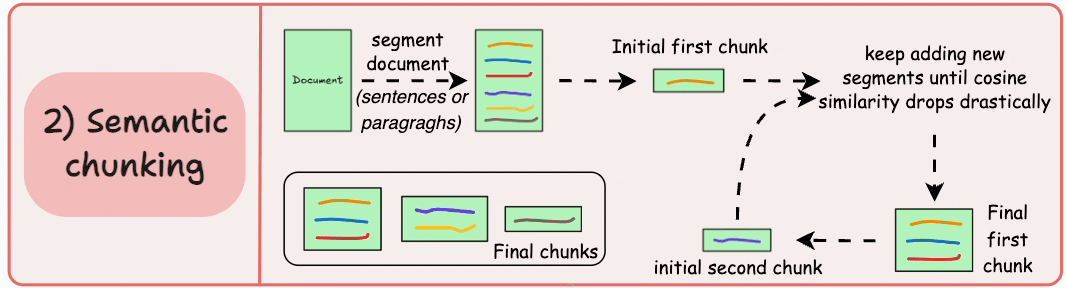

* Greg Kamradt popularized what's known as the **semantic chunker** with his [5 Levels of Text Splitting notebook](https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/main/tutorials/LevelsOfTextSplitting/5_Levels_Of_Text_Splitting.ipynb) here which takes a different approach from fixed character/token chunking.

* Instead of splitting text at predetermined positions or separators, it **uses embeddings to find natural semantic boundaries to keep semantically similar chunks of text together** in the text while maintaining consistent chunk sizes.

## How this works
* ChromaDB modified the algorithm to provide improved size control through **binary search**.
  * The chunker first splits text into small fixed-size pieces (around 50 tokens) using standard recursive splitting with separators.
  * For each piece, it looks at surrounding context (3 segments before and after) to understand the local meaning - this helps maintain semantic coherence across potential split points.

* After embedding these contextualized pieces, it calculates cosine distances between consecutive segments in a **sliding window technique**.
* Higher distances suggest natural topic transitions that make good splitting points.
* But rather than using Kamradt's original fixed percentile approach for choosing split points, **ChromaDB's version uses binary search to find a similarity threshold that produces chunks close to the target size.**
  * The binary search starts with limits of 0.0 and 1.0, calculating the midpoint threshold and counting how many splits it would create.
    * If there are too many splits, it raises the threshold by adjusting the lower limit;
    * Too few splits, it lowers the threshold by adjusting the upper limit.
    * This continues until it finds a threshold that creates chunks of approximately the desired size.

* This modification makes the chunker more practical by balancing semantic coherence with consistent chunk sizes.
* While the original version could produce unpredictably large chunks, the modified version maintains better size control while still respecting natural topic boundaries in the text.

## Original Semantic Chunker Implementation
* Can create unpredictably small or large chunks

In [22]:
## setup openai key
import os
from getpass import getpass

##enter openai key
OPENAI_API_KEY = getpass("Enter your Open AI API key: ")

Enter your Open AI API key: ··········


In [23]:
## setup openai environment
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

In [24]:
# Helper Function from the Repo that Returns Embeddings
embedding_function = embedding_functions.OpenAIEmbeddingFunction(api_key=OPENAI_API_KEY,
                                                                 model_name="text-embedding-3-large")

In [26]:
%%capture
!pip install langchain-experimental langchain langchain-openai

In [27]:
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai.embeddings import OpenAIEmbeddings


## init semantic chunker with OpenAI embeddings
lc_semantic_chunker = SemanticChunker(OpenAIEmbeddings())


## create semantic chunks
lc_semantic_chunks = lc_semantic_chunker.create_documents([document])

In [28]:
print("# of Chunks:", len(lc_semantic_chunks), "\n")
print(lc_semantic_chunks[199].page_content)
print("\n\n", "="*50, "\n\n")
print(lc_semantic_chunks[200].page_content)
print("\n\n", "="*50, "\n\n")

count_tokens(lc_semantic_chunks[199].page_content)
count_tokens(lc_semantic_chunks[200].page_content)

# of Chunks: 239 

When we
come around, you turn your back; and then whatever we’ve put in the
pan, don’t you let on you see it at all. And don’t you look when Jim
unloads the pan—something might happen, I don’t know what. And above
all, don’t you _handle_ the witch-things.”

“_Hannel_ ’m, Mars Sid? What _is_ you a-talkin’ ’bout? I wouldn’ lay de
weight er my finger on um, not f’r ten hund’d thous’n billion dollars,
I wouldn’t.”




CHAPTER XXXVII. That was all fixed. So then we went away and went to the rubbage-pile
in the back yard, where they keep the old boots, and rags, and pieces
of bottles, and wore-out tin things, and all such truck, and scratched
around and found an old tin washpan, and stopped up the holes as well
as we could, to bake the pie in, and took it down cellar and stole it
full of flour and started for breakfast, and found a couple of
shingle-nails that Tom said would be handy for a prisoner to scrabble
his name and sorrows on the dungeon walls with, and dropped one

## ChromaDB's Modified Semantic Chunker

In [29]:
## chromaDB's modified chunker
kamradt_chunker = KamradtModifiedChunker(
    avg_chunk_size=400,      # Target size in tokens
    min_chunk_size=50,       # Initial split size
    embedding_function=embedding_function  # Pass your embedding function
)

# Split your text
modified_kamradt_chunks = kamradt_chunker.split_text(document)

In [30]:
analyze_chunks(modified_kamradt_chunks, use_tokens=True)
print("\n\n", "="*50, "\n\n")
count_tokens(modified_kamradt_chunks[200])


Number of Chunks: 389

 ================================================== 200th Chunk ================================================== 
 answers the bell. Next morning, ‘Chop off her head.’ And he made every
one of them tell him a tale every night; and he kept that up till he had hogged a thousand and one tales that way, and then he put them all
in a book, and called it Domesday Book—which was a good name and stated the case. You don’t know kings, Jim, but I know them; and this old rip
of ourn is one of the cleanest I’ve struck in history. Well, Henry he takes a notion he wants to get up some trouble with this country. How
does he go at it—give notice?—give the country a show? No. All of a sudden he heaves all the tea in Boston Harbor overboard, and whacks out
a declaration of independence, and dares them to come on. That was

 ================================================== 201st Chunk ================================================== 
 _his_ style—he never give anybody a chan

### Summary
* We can see there is a difference in the chunk sizes between the 2 methods.
* There is another semantic chunker method that I did not try here that we could try in the future:
  * Semantic Chunkers is a multi-modal chunking python library for intelligent chunking of text, video, and audio. It makes your AI and data processing more efficient and accurate.
  * The specific repo for this library: https://github.com/aurelio-labs/semantic-chunkers?tab=readme-ov-file
  * Semantic chunkers allow us to build LLM applications that are more "context aware" of information. This prevents any semantic or contextual overlap in the text if we split chunks recursively.

# 6. Cluster Semantic Chunker
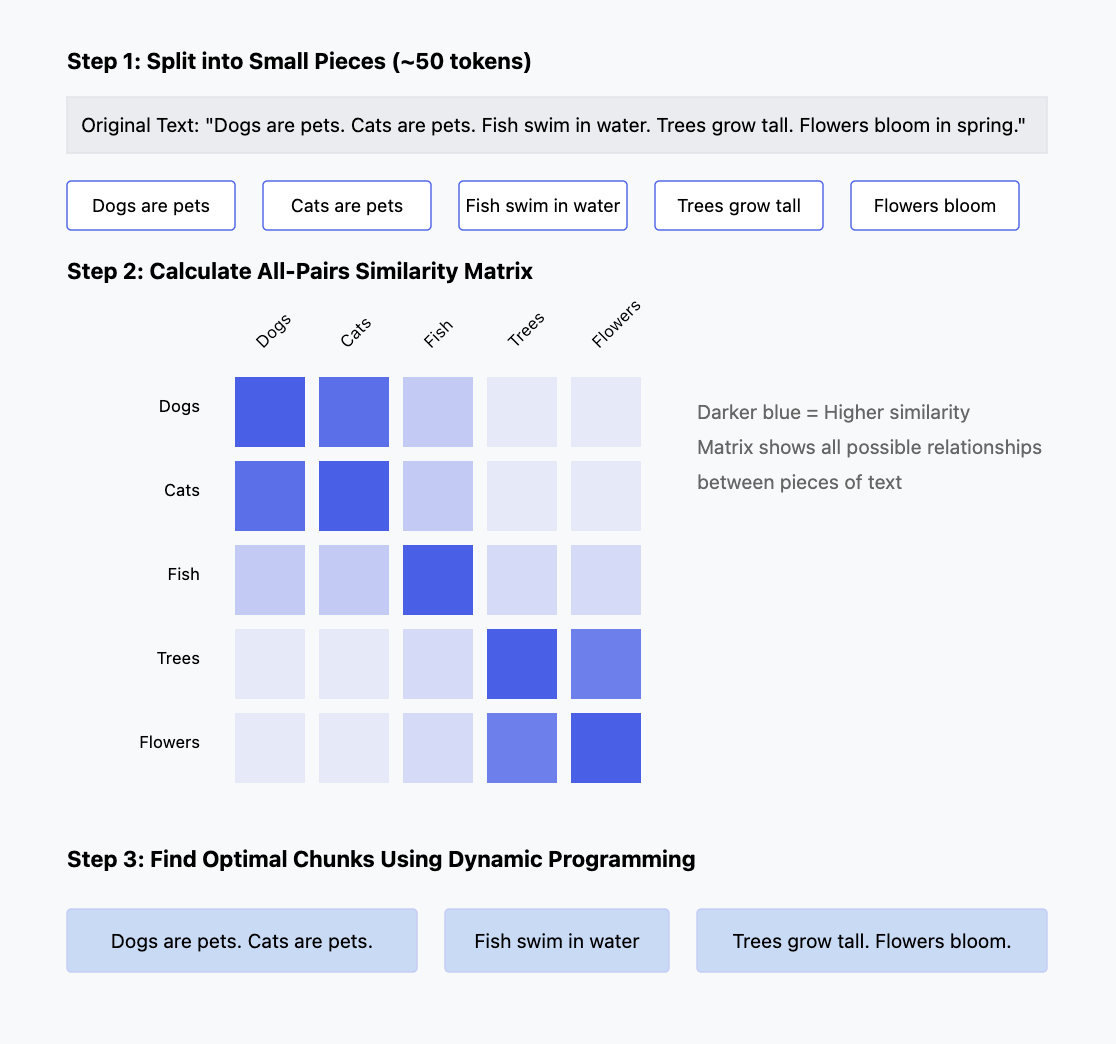

* The `ClusterSemanticChunker` takes a **global optimization approach to chunking**,
  * This is a significant contrast to kamradt's semantic local decisions about split points based on sliding windows.
  * Rather than looking through a **sliding window of context, it considers relationships between all pieces of text simultaneously to find the most semantically coherent groupings while maintaining size constraints.**

## How it works
* The process begins similar to other chunkers by splitting text into small fixed-size pieces (defaulting to around 50 tokens) using standard recursive splitting.
* However, instead of only analyzing consecutive pieces, it creates a **similarity matrix** by embedding each piece and calculating cosine similarities between all possible pairs.
  * **This gives the chunker a complete view of semantic relationships throughout the document.**

* Using this similarity matrix, the chunker employs **dynamic programming** to find the optimal way to group pieces into chunks.
  * For each position in the text, it tries different possible chunk sizes and calculates a "reward" based on the total semantic similarity between all pieces within that potential chunk.
  * By building up from small pieces and saving intermediate results, it efficiently explores the space of possible chunkings to find a global optimum.

* The size constraints are enforced by limiting the maximum number of pieces that can be combined into a chunk (max_cluster).
  * Within this limit, the algorithm is free to create chunks that **maximize semantic coherence.**
  * This leads to more natural groupings than approaches that only look at local context, as it can recognize when pieces far apart in the text are actually closely related.

* **This global optimization strategy helps avoid some common pitfalls of sliding window approaches.**
  * While local methods might miss opportunities to group related content that's separated by a brief topic shift, the cluster approach can see these relationships in its similarity matrix.
  * **The result is chunks that more accurately reflect the semantic structure of the document while still maintaining practical size limits for downstream processing.**

In [33]:
## init ClusterSemanticChunker
cluster_chunker = ClusterSemanticChunker(
    embedding_function=embedding_function,
    max_chunk_size=400,
    length_function=openai_token_count
)

## create chunks
cluster_chunker_chunks = cluster_chunker.split_text(document)

## analyze chunks
analyze_chunks(cluster_chunker_chunks, use_tokens=True)


Number of Chunks: 770

 ================================================== 200th Chunk ================================================== 
 I was so excited my hands shook so I couldn’t hardly do anything with
them. As soon as I got started I took out after the raft, hot and heavy,
right down the tow-head. That was all right as far as it went, but the tow-head warn’t sixty yards long, and the minute I flew by the foot of
it I shot out into the solid white fog, and hadn’t no more idea which
way I was going than a dead man. Thinks I, it won’t do to paddle; first I know I’ll run into the bank or
a tow-head or something; I got to set still and float, and yet it’s mighty fidgety business to have to hold your hands still at such a
time. I whooped and listened. Away down there somewheres I hears a small whoop, and up comes my spirits. I went tearing after it,
listening sharp to hear it again. The next time it come, I see I warn’t heading for it, but heading away to the right of it. And the n

# 7. LLM Semantic Chunker
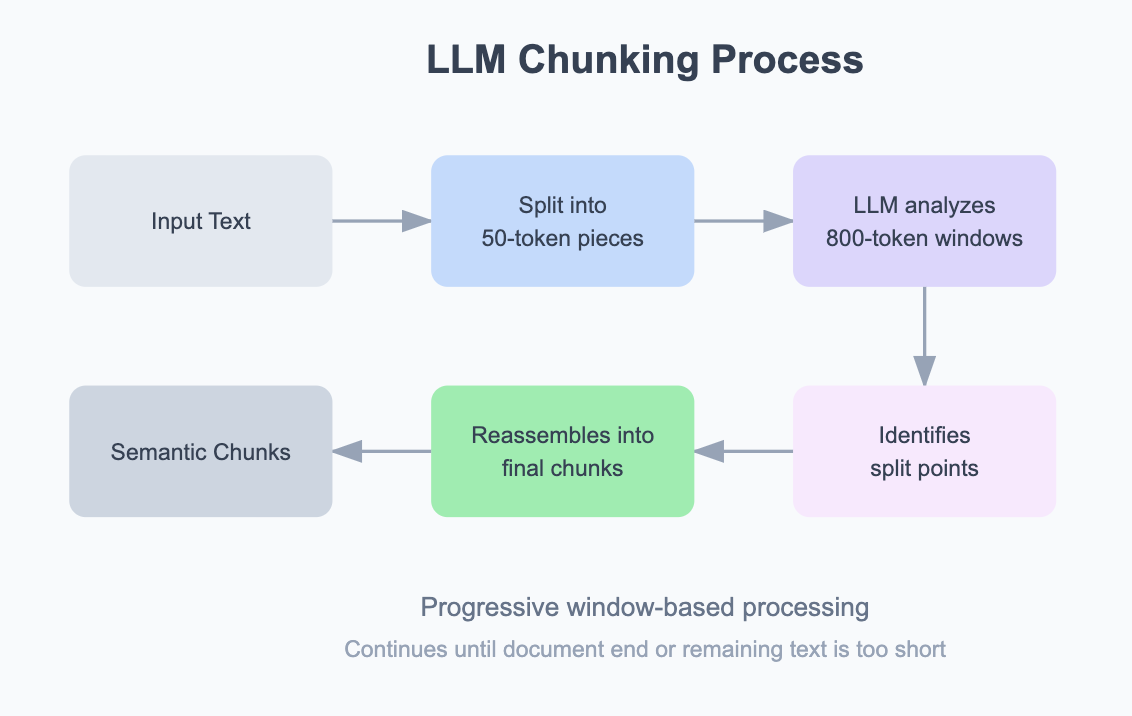

* The LLM Semantic Chunker takes a direct approach to document chunking by literally asking an LLM to identify semantic boundaries.
  * The process begins by dividing the input text into small, fixed-size pieces of around 50 tokens using a standard recursive splitter, creating manageable units for the LLM to analyze.
  * These pieces are then wrapped with special tags like <start_chunk_1> and <end_chunk_1> to maintain their identity throughout the process.

* The core of the chunking process involves presenting text to the LLM in windows of approximately 800 tokens (containing multiple small pieces) at a time.
  * For each window, the LLM is instructed to identify natural semantic breaks, responding in a specific format like split_after: X, Y, Z where X, Y, Z are chunk numbers.
  
  * These splits must be in ascending order and must start from the current position, with at least one split being required to ensure the process continues moving forward.

* The chunker maintains a **sliding window approach**, progressively moving through the document based on the LLM's last suggested split point.
* This continues until either the end of the document is reached or the remaining text becomes too short to require further splitting (less than ~4 chunks).
* The suggested split points are then used to reassemble the small pieces into final chunks, with each chunk combining all pieces between two split points.

**Internally, the system prompt follows:**
```
"You are an assistant specialized in splitting text into thematically consistent sections. "
"The text has been divided into chunks, each marked with <|start_chunk_X|> and <|end_chunk_X|> tags, where X is the chunk number. "
"Your task is to identify the points where splits should occur, such that consecutive chunks of similar themes stay together. "
"Respond with a list of chunk IDs where you believe a split should be made. For example, if chunks 1 and 2 belong together but chunk 3 starts a new topic, you would suggest a split after chunk 2. THE CHUNKS MUST BE IN ASCENDING ORDER."
"Your response should be in the form: 'split_after: 3, 5'."
```

In [34]:
## init LLMSemanticChunker
llm_chunker = LLMSemanticChunker(
    organisation="openai",
    model_name="gpt-4o",
    api_key=OPENAI_API_KEY)

## chunk document
llm_chunker_chunks = llm_chunker.split_text(document)

## analyze chunks
analyze_chunks(llm_chunker_chunks, use_tokens=True)

Processing chunks: 100%|█████████▉| 4520/4522 [12:14<00:00,  6.16it/s]


Number of Chunks: 571

 ================================================== 200th Chunk ================================================== 
 The place to buy canoes is off of rafts laying up at shore. But we
didn’t see no rafts laying up; so we went along during three hours and more. Well, the night got gray and ruther thick, which is the next
meanest thing to fog. You can’t tell the shape of the river, and you can’t see no distance. It got to be very late and still, and then along
comes a steamboat up the river. We lit the lantern, and judged she would see it. Up-stream boats didn’t generly come close to us; they go
out and follow the bars and hunt for easy water under the reefs; but
nights like this they bull right up the channel against the whole river.

 ================================================== 201st Chunk ================================================== 
 We could hear her pounding along, but we didn’t see her good till she
was close. She aimed right for us. Often they

# Critical Review of ChromaDB's Paper - What Chunking Method(s) are/is the best?

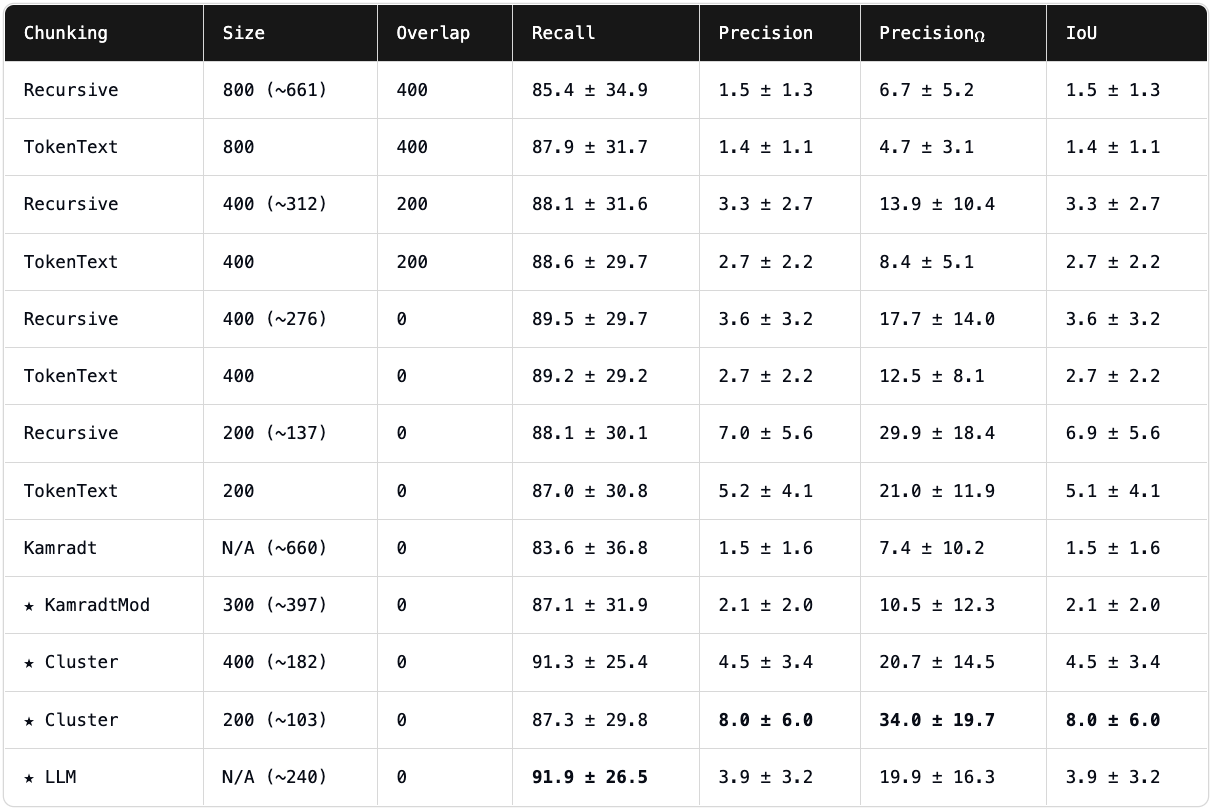

1. **Recall**
  * Measures what percentage of the relevant tokens were successfully retrieved.
  * For a given query, it's calculated as:
```
Recall = |relevant_tokens ∩ retrieved_tokens| / |relevant_tokens|
```
2. **Precision**
  * Measures what percentage of retrieved tokens were actually relevant.
  * This is Calculated as:
  ```
Precision = |relevant_tokens ∩ retrieved_tokens| / |retrieved_tokens|
```
3. **Precision Ω (Precision with perfect recall)**
  * This is a theoretical maximum precision score that assumes all chunks containing relevant tokens are successfully retrieved.
  * It helps understand the inherent token efficiency of a chunking strategy.

4. **IoU (Intersection over Union)**
  * This is similar to the Jaccard similarity coefficient, measuring the overlap between relevant and retrieved tokens while accounting for redundancy.
  * This is Calculated as:
```
IoU = |relevant_tokens ∩ retrieved_tokens| / (|relevant_tokens| + |retrieved_tokens| - |relevant_tokens ∩ retrieved_tokens|)
```

These metrics are averaged across all queries and corpora in the evaluation.

The ± values show standard deviation.


# ChromaDB interesting findings

Key notes from Chroma:

1. Higher values are better for all metrics

2. Token-level evaluation approaches differ from traditional Information Retrieval metrics which focus on document-level relevance and ranking, making it **more suitable for evaluating RAG (Retrieval Augmented Generation) systems.**

3. Token-level evaluation captures not just whether relevant information was retrieved but also how efficiently (how many irrelevant tokens were included).

4. IoU penalizes both missing relevant tokens and including irrelevant ones, making it a good overall measure of chunking efficiency


# Chunking -- Overall Findings and Summary
1. **Best Overall Performance**
  * The `ClusterSemanticChunker` with 400 tokens achieved the second-highest recall (91.3%) while maintaining decent efficiency
  * The `LLMSemanticChunker` achieved the highest recall (91.9%) with average efficiency metrics
  * The `ClusterSemanticChunker` with 200 tokens achieved the highest precision (8.0%), PrecisionΩ (34.0%), and IoU (8.0%)

2. **Practical Recommendations for Chunking**
  * The `RecursiveCharacterTextSplitter` with chunk size 200 and no overlap performs consistently well across all metrics (88.1% recall, 7.0% precision, 29.9% PrecisionΩ)
  * This is significant because it's a simpler, more commonly available method

3. **Important Findings worth noting**
  * Reducing chunk overlap generally improves IoU scores by reducing redundant information
  * OpenAI's default settings (800 tokens with 400 overlap) resulted in below-average recall and the lowest scores across other metrics
  * Smaller chunk sizes (200-400 tokens) generally performed better than larger ones (800 tokens)
  * Adding overlap between chunks generally decreased efficiency metrics while only marginally improving recall

4. **Surprising Results**
  * The simple `RecursiveCharacterTextSplitter` performed competitively with more sophisticated semantic approaches
  * The default settings for popular chunking strategies (like OpenAI's) were suboptimal
  * The LLM-based chunker performed well despite its simplicity

# **Main Takeaway**
* If you are implementing an LLM-RAG system today, this suggests that you should either:

1. Use `RecursiveCharacterTextSplitter` with 200-400 token chunks and no overlap for a simple, effective solution.

2. Use `ClusterSemanticChunker` with 200-400 tokens if you need maximum performance and can handle the additional complexity.
